# Which restaurant and where you should open it in Brooklyn?

Recommendation on where and which kind of restaurants open in the Brooklyn borough of New York city. These recommendations are derived using only demographic considerations. The data sources are:

-  https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/data
- Foursquare

We will use unsupervised learning methods to classify the city neighborhoods. Then for each class of neighborhoods we will find where, based on demographic data, a restaurant can be open and which kind of restaurants are better the other in a given area. 

### Brooklyn neighborhood coordinates and populations.

Necessary Libraries:

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import json
import requests as req
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import datetime

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

from sklearn import preprocessing
from sklearn.cluster import KMeans
!conda install -c conda-forge scikit-learn --yes

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!conda install -c conda-forge folium=0.5.0 --yes
import folium as fo
print('Libraries imported.')

Matplotlib version:  3.0.0
Solving environment: done

# All requested packages already installed.

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda

  added / updated specs: 
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geopy-1.17.0               |             py_0          49 KB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          82 KB

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.17.0-py_0 conda-forge


geopy-1.17.0         | 49 KB     | ##################################### | 100% 
geographiclib-1.49   | 32 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying 

We need a database of the city of New York where the population per neighborhoods is displayed. Such a database exist and it is provided by the City of New York (See https://data.cityofnewyork.us/City-Government/New-York-City-Population-By-Neighborhood-Tabulatio/swpk-hqdp/data). From this database we can download a CSV file containing for the year 2010 (last available year) the information regarding the Brooklyn borough (the one we are interested in). 

In [2]:
df_ny = pd.read_csv('ny_pop_data.csv',sep=',')
df_ny

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Brooklyn,2010,47,BK09,Brooklyn Heights-Cobble Hill,22887
1,Brooklyn,2010,47,BK17,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518
2,Brooklyn,2010,47,BK19,Brighton Beach,35547
3,Brooklyn,2010,47,BK21,Seagate-Coney Island,31965
4,Brooklyn,2010,47,BK23,West Brighton,17750
5,Brooklyn,2010,47,BK25,Homecrest,44316
6,Brooklyn,2010,47,BK26,Gravesend,29436
7,Brooklyn,2010,47,BK27,Bath Beach,29931
8,Brooklyn,2010,47,BK28,Bensonhurst West,88727
9,Brooklyn,2010,47,BK29,Bensonhurst East,62978


To get the coordinates of the neighborhoods we will use Geopy. Geopy does not _always_ distinguish between neighborhoods whose names differ by a cardinal point name. For example:

In [3]:
test1='Bensonhurst West'
test2='Bensonhurst East'
#test1='Sunset Park West'
#test2='Sunset Park East'
#test2='Sunset Park'


geolocator = Nominatim()
test1=test1+', NY'
test2=test2+', NY'
location = geolocator.geocode(test1)
lat1 = location.latitude
lon1 = location.longitude
location = geolocator.geocode(test2)
lat2 = location.latitude
lon2 = location.longitude
print('The geograpical coordinate of {} are {},{} \nThe geograpical coordinate of {} are {},{}'.format(test1,lat1,lon1,test2,lat2,lon2))

/home/jupyterlab/conda/lib/python3.6/site-packages/geopy/geocoders/osm.py:143: UserWarning: Using Nominatim with the default "geopy/1.17.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  UserWarning


The geograpical coordinate of Bensonhurst West, NY are 40.6049772,-73.9934061 
The geograpical coordinate of Bensonhurst East, NY are 40.6049772,-73.9934061


This shows that ```Bensonhurst West``` and ```Bensonhurst East``` would have the same coordinates. Hence we simply sum the population in the columns having the same name and rename the neighborhood removing the cardinal point. Other problems comes from the name ``` North Side - South Side ``` (Geopy return error), which is a sub-neighborhood of ``` Williamsburg  ``` and for this reason we sum the population in these two neighborhoods. Similar problems happen with ```East Williamsburg``` and ```Williamsburg``` and also for ```Bushwick North``` and ```Bushwick South```. Again we sum the population in the rows. Finally, Geopy returns the wrong coordinates for ```Sunset Park West``` and ```Sunset Park East```: again changing the name in ```Sunset Park``` we obtain the correct coordinates. For this reason we sum the population of these two neighborhoods too.

In [4]:
# Fix 'Bensonhurst West' and 'Bensonhurst East'.
df_ny.at[8,'Population'] = df_ny.at[8,'Population']+df_ny.at[9,'Population']
df_ny.at[8,'NTA Name'] = 'Bensonhurst'

# Fix 'Sunset Park West' and 'Sunset Park East'.
df_ny.at[12,'Population'] = df_ny.at[12,'Population']+df_ny.at[14,'Population']
df_ny.at[12,'NTA Name'] = 'Sunset Park'

# Fix 'North Side - South Side', 'Williamsburg' and 'East Williamsburg'.
df_ny.at[33,'Population'] = df_ny.at[33,'Population']+df_ny.at[34,'Population']+df_ny.at[45,'Population']

# Fix 'Bushwick North' and 'Bushwick South'
df_ny.at[37,'Population'] = df_ny.at[37,'Population']+df_ny.at[38,'Population']
df_ny.at[37,'NTA Name'] = 'Bushwick'

# Drop rows
df_ny = df_ny.drop(df_ny.index[len(df_ny)-1]) #drop the last row
df_ny = df_ny.drop(df_ny.index[45])
df_ny = df_ny.drop(df_ny.index[38])
df_ny = df_ny.drop(df_ny.index[34])
df_ny = df_ny.drop(df_ny.index[14])
df_ny = df_ny.drop(df_ny.index[9])

df_ny

,Borough,Year,FIPS County Code,NTA Code,NTA Name,Population
0,Brooklyn,2010,47,BK09,Brooklyn Heights-Cobble Hill,22887
1,Brooklyn,2010,47,BK17,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518
2,Brooklyn,2010,47,BK19,Brighton Beach,35547
3,Brooklyn,2010,47,BK21,Seagate-Coney Island,31965
4,Brooklyn,2010,47,BK23,West Brighton,17750
5,Brooklyn,2010,47,BK25,Homecrest,44316
6,Brooklyn,2010,47,BK26,Gravesend,29436
7,Brooklyn,2010,47,BK27,Bath Beach,29931
8,Brooklyn,2010,47,BK28,Bensonhurst,151705
10,Brooklyn,2010,47,BK30,Dyker Heights,42419


Moreover Geopy return error for ```East New York (Pennsylvania Ave)```. Since ```East New York, Pennsylvania Ave``` would return the same coordinates of ```East New York```, we change the name of this neighborhood in simply ```Pennsylvania Ave```. A similar problem happens for the neighborhood called ```Madison```: Geopy is unable to return the coordinates of the neighborhood in Brooklyn (rather it returns the coordinate of 'Madison Ave' in Manhattan). For this reason we replace its name with the name of a street belonging to this neighborhood (in particular ```Bedford Ave```).

In [5]:
df_ny.at[43,'NTA Name'] = 'Pennsylvania Ave'
df_ny.at[22,'NTA Name'] = 'Bedford Ave'

Now we drop all the unnecessary columns and rename them.

In [6]:
df_ny.reset_index(drop=True,inplace=True)
df_ny.drop(['Borough','Year','FIPS County Code','NTA Code'],axis=1,inplace=True)
df_ny.rename(columns={'NTA Name':'neigh_name','Population':'pop'},inplace=True)
df_ny

,neigh_name,pop
0,Brooklyn Heights-Cobble Hill,22887
1,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518
2,Brighton Beach,35547
3,Seagate-Coney Island,31965
4,West Brighton,17750
5,Homecrest,44316
6,Gravesend,29436
7,Bath Beach,29931
8,Bensonhurst,151705
9,Dyker Heights,42419


At this point we are ready to retrieve the coordinates of each neighborhood from Geopy. However there are still some technicalities:

1. There are neighborhood names which are just abbreviation of the original name (e.g. ```Bch``` stands for ```Beach```, and so on). To overcome this difficulty we may simply replace the abbreviation (A) with the original name (ON) using the command ```.replace(A, ON)``` on the string containing the neighborhood name.

2. There are composite neighborhood names, like for example ```Brooklyn Heights-Cobble Hill```. In this case, we assign as coordinates the average coordinates of the all the neighborhoods composing the name, since they are neighboring.

3. For the neighborhood named ```Prospect Lefferts Gardens-Wingate```, there are two problems: ```Prospect Lefferts Gardens``` is too long for Geopy (error is returned), and ```Windgate``` cannot be found by Geopy. The first problem can be solved eliminating the word ```Prospect```(Geopy returns the correct coordinates), while the second problem is simply solved adding ```Park``` (Geopy returns the coordinates of the park, which is the Windgate neighborhood).

The scrip below generates the database we are looking for.

In [7]:
geolocator = Nominatim(timeout=3)
coord_list=[]
print('Wait...')

for name in df_ny['neigh_name']:
    
    num=name.count('-')

    if num>0:
    
        rest=name.split('-',num)
        la_tmp=0
        lo_tmp=0
    
        for na in rest:
 
            if na.find('Wingate')>0:
        
                na = na+' Park'
            
            na2=na.replace("Brklyn","Brooklyn").replace('Bch','Beach').replace('Manhattn','Manhattan').replace('Prospect ','')+', Brooklyn, NY'
            location = geolocator.geocode(na2)
            lat_na = location.latitude
            lon_na = location.longitude
            la_tmp = la_tmp+lat_na
            lo_tmp = lo_tmp+lon_na
            lat=round(la_tmp/(num+1),7)
            lon=round(lo_tmp/(num+1),7)
            #print('{}:{},{}'.format(na2,lat_na,lon_na))
    
        #print('The coordinates of {} are {},{}'.format(name,lat,lon))
        coord_list.append({'lat':lat, 'lon':lon})

    else:

        if name.find('Wingate')>0: 
            
                name = name+' Park'
                
        name=name.replace("Brklyn","Brooklyn").replace('Bch','Beach').replace('Manhattn','Manhattan').replace('Prospect ','')+', Brooklyn, NY'
        location = geolocator.geocode(name)
        lat = location.latitude
        lon = location.longitude
        #print('The coordinates of {} are {},{}'.format(name,lat,lon))
        coord_list.append({'lat':lat, 'lon':lon}) 

print('\nDone!')
df_tmp=pd.DataFrame(coord_list)
df_ny2=df_ny.join(df_tmp)
df_ny2

Wait...

Done!


,neigh_name,pop,lat,lon
0,Brooklyn Heights-Cobble Hill,22887,40.691792,-73.996542
1,Sheepshead Bay-Gerritsen Beach-Manhattn Bch,64518,40.584097,-73.937690
2,Brighton Beach,35547,40.579644,-73.961111
3,Seagate-Coney Island,31965,40.575938,-73.996230
4,West Brighton,17750,40.578087,-73.974925
5,Homecrest,44316,40.586118,-73.957307
6,Gravesend,29436,40.596134,-73.973943
7,Bath Beach,29931,40.601850,-74.000501
8,Bensonhurst,151705,40.604977,-73.993406
9,Dyker Heights,42419,40.620472,-74.011667


Let us print a map of Brooklyn with the neighborhoods of the database ```df_ny2``` to check if everything worked properly.

In [8]:
# Retrieve the coordinate to center the map
bro= 'Brooklyn, NY'

geolocator = Nominatim()
location = geolocator.geocode(bro)
lat_bro = location.latitude
lon_bro = location.longitude

# Create the map of Brooklyn 
map_bro = fo.Map(location=[lat_bro, lon_bro], zoom_start=11)

# Add markers to map
for lat, lng, name,pop in zip(df_ny2['lat'], df_ny2['lon'], df_ny2['neigh_name'],df_ny2['pop']):
    label = fo.Popup(name+', population:'+str(pop), parse_html=True)
    fo.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bro)  
    
map_bro

### Retrieve information on restaurants in Brooklyn.

In this section we create a database containing informations on the restaurants and their category for each Brooklyn neighborhoods. The data will be obtained using the 'search' functionality of Foursquare with query 'Restaurant'.

Foursquare setting

In [14]:
CLIENT_ID = '3FTNYFFWXYMEPZDEKDQE0O03VSBTSJK4SBRPPHRQH4GXLIYZ'
CLIENT_SECRET = '3YRBYJH3ZOXHAV25ZCDCBJHCKRIG5DYQFXTTRJHZT304KALE'
VERSION = 20181211#datetime.date.today().strftime("%Y%m%d")
LIMIT = 50
RADIUS = 750
QUERY = 'Restaurant' 

The function below implement the search operation of a given query in Foursquare. The information retrieved are:

1. The restaurant coordinates.
2. The restaurant name.
3. The kind of restaurant according to Foursquare.

In [15]:
def search_info(query,names,latitudes,longitudes,rad,lim):
    
    print('Wait...')
    res_list=[]
    i=0
    for na,la,lo in zip(names,latitudes,longitudes):
        
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&query={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            query,
            la, 
            lo, 
            rad, 
            lim)
        res = req.get(url).json()
        if(res['response']=={}):
            
            print('Error: ', res['meta']['code'],'\nError message: ',res['meta']['errorDetail'])
            break
         
            
        res_list.append([(data['name'],
                         data['location']['lat'],
                         data['location']['lng'],
                         na,
                         la,
                         lo,
                         str([cate['shortName'] for cate in data['categories']]) )for data in res['response']['venues']])
        i=i+1
        
    df_res = pd.DataFrame([item for restaurant in res_list for item in restaurant], columns=['name','res_lat','res_lon','neigh_name','neigh_lat','neigh_lon','category'])
    df_res['category'] = df_res['category'].map(lambda x: x.lstrip('[\' ').rstrip('\'] '))
    print('Done!\n\nNumber of calls:',i)
    return(df_res)

We fill the database with the information retrieved from Foursquare.

In [16]:
df_rest = search_info(query=QUERY,
                      names=df_ny2['neigh_name'],
                      latitudes=df_ny2['lat'],
                      longitudes=df_ny2['lon'],
                      rad=RADIUS,
                      lim=LIMIT)
df_rest.head()

Wait...
Done!

Number of calls: 45


,name,res_lat,res_lon,neigh_name,neigh_lat,neigh_lon,category
0,The Archives Restaurant & Bar,40.693557,-73.988722,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Hotel Bar
1,Awash Ethiopian Restaurant,40.685740,-73.994393,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Ethiopian
2,Sultan Restaurant & Cafe Lounge,40.690392,-73.994956,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Mediterranean
3,Caruso Pizzeria & Restaurant,40.686615,-73.990587,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Pizza
4,Clark's Restaurant,40.697533,-73.993044,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Diner


Let us draw a map with the restaurants location in order to get some information about their geographical distribution. 

In [17]:
map_bro_res = fo.Map(location=[lat_bro, lon_bro], zoom_start=11)

# Add markers to map
for lat, lng, name,cat in zip(df_rest['res_lat'], df_rest['res_lon'], df_rest['name'],df_rest['category']):
    label = fo.Popup('name: '+name+', category:'+cat, parse_html=True)
    fo.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bro_res)  
    
map_bro_res

We now transform the categorical variable ```category``` into a numerical one in order to do statistics.

In [18]:
df_rest_num = pd.get_dummies(df_rest[['category']],prefix='',prefix_sep='')
df_rest_num.rename(columns={'': 'no_category'},inplace=True)
df_rest_d = pd.concat([df_rest,df_rest_num],axis=1)
df_rest_d2 = df_rest_d.drop(['res_lat','res_lon','neigh_lat','neigh_lon','name','category'],axis=1)
#df_rest_d2.head()

In [19]:
df_rest_d2.shape

(1361, 80)

Not all the categories returned are associated to a restaurant. For instance ```Arcade``` or ```Event Services``` are clearly not restaurants category. Other categories does not allow to do any classification, like for instance the categories ```Restaurants``` or ```Food```. Hence we drop all the columns of this kind.

In [20]:
df_rest_d2.drop(['no_category','Arcade','Bar','Bakery','Breakfast','Classroom','Cocktail','Cafeteria','Café','Coffee Shop',
              'Design','Event Services','Event Space','Food','Grocery Store','Historic Site','Hookah Bar',
              'Hotel Bar','Hotpot','Industrial Estate','Juice Bar','Laundry','Lounge','Nightclub',
              'Office','Pub','Restaurant','Shop','Snacks','Sports Bar','Supermarket'],axis=1,inplace=True)

Now we count the total number of reastaurnat in each neighborhood.

In [21]:
df_grup = df_rest_d2.groupby('neigh_name').sum().reset_index()
df_grup['total']=df_grup.sum(axis=1) # Total number of restaurants counting also the uncategorized one
df_grup.head()

,neigh_name,African,American,Asian,Cajun / Creole,Cantonese,Caribbean,Chinese,Colombian,Deli / Bodega,Diner,Eastern European,Egyptian Restaurant,Ethiopian,Fast Food,French,Gastropub,Greek,Indian,Italian,Japanese,Kebab,Kosher,Latin American,Malay,Mediterranean,Mexican,Middle Eastern,New American,Paella,Pakistani,Peruvian,Pizza,Polish,Russian,Sandwiches,Seafood,Shanghai,South American,Southern / Soul,Spanish,Steakhouse,Sushi,Tacos,Tapas,Thai,Turkish,Vegetarian / Vegan,Vietnamese,total
0,Bath Beach,0,1,1,0,2,0,17,0,0,0,2,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,1,0,0,1,0,3,0,0,1,2,1,0,0,1,0,0,0,0,0,1,0,1,40
1,Bay Ridge,1,2,1,0,0,0,2,0,0,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2,6,0,0,0,0,2,0,0,1,1,0,0,0,3,0,0,0,0,1,1,0,0,29
2,Bedford,0,0,0,0,0,0,2,0,0,1,2,0,0,0,2,1,0,0,7,1,0,0,1,0,1,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,28
3,Bedford Ave,0,1,0,0,0,0,4,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,13
4,Bensonhurst,0,1,0,0,3,0,17,0,0,1,2,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,1,0,0,1,0,2,0,0,1,2,1,0,0,0,0,1,0,0,0,1,0,0,39


Let us get some infomration on the database.

In [22]:
df_grup.shape

(45, 50)

Hence all the neighborhoods have restaurants . We now perform an right outer join between the database containing the geographic data, ```df_ny2```, and the database containing the information about restaurants, ```df_grup```. In this way we add the population data to the final database. In this way even if we have no restaurant in a neighborhood, it will be present in the final database.

In [23]:
df_tmp = df_ny2[['neigh_name','pop']]
df_grup = df_grup.merge(df_tmp,on='neigh_name',how='right')
df_grup.head()

,neigh_name,African,American,Asian,Cajun / Creole,Cantonese,Caribbean,Chinese,Colombian,Deli / Bodega,Diner,Eastern European,Egyptian Restaurant,Ethiopian,Fast Food,French,Gastropub,Greek,Indian,Italian,Japanese,Kebab,Kosher,Latin American,Malay,Mediterranean,Mexican,Middle Eastern,New American,Paella,Pakistani,Peruvian,Pizza,Polish,Russian,Sandwiches,Seafood,Shanghai,South American,Southern / Soul,Spanish,Steakhouse,Sushi,Tacos,Tapas,Thai,Turkish,Vegetarian / Vegan,Vietnamese,total,pop
0,Bath Beach,0,1,1,0,2,0,17,0,0,0,2,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,1,0,0,1,0,3,0,0,1,2,1,0,0,1,0,0,0,0,0,1,0,1,40,29931
1,Bay Ridge,1,2,1,0,0,0,2,0,0,3,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,2,6,0,0,0,0,2,0,0,1,1,0,0,0,3,0,0,0,0,1,1,0,0,29,79371
2,Bedford,0,0,0,0,0,0,2,0,0,1,2,0,0,0,2,1,0,0,7,1,0,0,1,0,1,3,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,0,3,0,0,0,28,70713
3,Bedford Ave,0,1,0,0,0,0,4,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2,13,38917
4,Bensonhurst,0,1,0,0,3,0,17,0,0,1,2,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,1,0,0,1,0,2,0,0,1,2,1,0,0,0,0,1,0,0,0,1,0,0,39,151705


We can now select all the columns where there are no categorized restaurants.

In [24]:
df_grup[df_grup['total']==0]

,neigh_name,African,American,Asian,Cajun / Creole,Cantonese,Caribbean,Chinese,Colombian,Deli / Bodega,Diner,Eastern European,Egyptian Restaurant,Ethiopian,Fast Food,French,Gastropub,Greek,Indian,Italian,Japanese,Kebab,Kosher,Latin American,Malay,Mediterranean,Mexican,Middle Eastern,New American,Paella,Pakistani,Peruvian,Pizza,Polish,Russian,Sandwiches,Seafood,Shanghai,South American,Southern / Soul,Spanish,Steakhouse,Sushi,Tacos,Tapas,Thai,Turkish,Vegetarian / Vegan,Vietnamese,total,pop
39,Starrett City,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13354


Now we add a column in the database containing the number of inhabitant per restaurants. This number give us an idea on the 'restaurants' concentration in a given area. We also sort the database in ascending order of this quantity.

In [25]:
df_grup['res_per_ab']=round(df_grup['pop']/df_grup['total'],1)
df_grup.fillna(0,inplace=True)
df_grup.sort_index(by=['res_per_ab'],ascending=True,inplace=True)
df_grup.reset_index(drop=True,inplace=True)
df_grup.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  This is separate from the ipykernel package so we can avoid doing imports until


,neigh_name,African,American,Asian,Cajun / Creole,Cantonese,Caribbean,Chinese,Colombian,Deli / Bodega,Diner,Eastern European,Egyptian Restaurant,Ethiopian,Fast Food,French,Gastropub,Greek,Indian,Italian,Japanese,Kebab,Kosher,Latin American,Malay,Mediterranean,Mexican,Middle Eastern,New American,Paella,Pakistani,Peruvian,Pizza,Polish,Russian,Sandwiches,Seafood,Shanghai,South American,Southern / Soul,Spanish,Steakhouse,Sushi,Tacos,Tapas,Thai,Turkish,Vegetarian / Vegan,Vietnamese,total,pop,res_per_ab
0,Fort Greene,0,1,0,0,0,3,7,0,0,2,0,0,1,0,1,0,0,2,2,0,0,0,1,0,0,3,2,0,0,0,0,4,0,0,2,1,0,0,2,1,0,0,0,1,2,0,0,0,38,26079,686.3
1,Brooklyn Heights-Cobble Hill,1,2,0,0,0,0,5,0,1,3,1,0,1,0,0,0,1,2,1,3,0,0,0,0,1,0,2,0,0,0,0,3,0,0,1,0,0,0,1,0,0,2,0,0,2,0,0,0,33,22887,693.5
2,Prospect Heights,1,5,0,0,0,0,3,0,0,2,1,0,0,0,0,0,0,2,1,3,0,0,0,0,1,0,2,1,0,0,0,0,0,0,2,0,0,1,0,0,0,2,0,0,1,0,0,0,28,19849,708.9
3,Bath Beach,0,1,1,0,2,0,17,0,0,0,2,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,1,0,0,1,0,3,0,0,1,2,1,0,0,1,0,0,0,0,0,1,0,1,40,29931,748.3
4,Clinton Hill,1,1,0,0,0,2,9,0,0,1,0,0,0,0,1,1,0,3,2,0,0,0,0,0,0,5,1,0,0,0,0,4,0,0,1,0,0,0,2,1,0,0,0,1,3,0,0,0,39,34791,892.1


To conclude we add to the database another useful paramter: the fraction of Brooklyn population living in a given neigborhood.

In [26]:
Total_pop = df_grup['pop'].sum()
df_grup['frac_pop']=100*df_grup['pop']/Total_pop

### Retrieve information on venues in Brooklyn.

For our analysis, it would be important to have some neighborhood classification. For example, it is more likely for a restaurant to have success in a commercial area rather than a residential one. Unfortunately, the database that the city of New York release, does not have this information. However, some classification of this sort can still be deduced from the kind of commercial activities in a given neighborhood. For instance, in a residential area it is more likely to find a laundry with respect to a commercial area. Similarly in a commercial area banks far more common than in a residential area.
To classify the neighborhoods we will use a K mean clustering algorithm . The data we use for this unsupervised classification algorithm will be retrieved from Foursquare using its 'explore' functionality.

In [27]:
# Update the Foursquare setting

#CLIENT_ID = '3FTNYFFWXYMEPZDEKDQE0O03VSBTSJK4SBRPPHRQH4GXLIYZ'
#CLIENT_SECRET = '3YRBYJH3ZOXHAV25ZCDCBJHCKRIG5DYQFXTTRJHZT304KALE'
#VERSION = datetime.date.today().strftime("%Y%m%d")
LIMIT = 300
RADIUS = 1000

This function retrurns a database containint the information on different venues for each neighborhood.

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius,limit):
    
    print('Wait...')
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        #print(name)
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
        results = req.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['neigh_name', 
                  'neigh_lat', 
                  'neigh_lon', 
                  'venue', 
                  'venue_lat', 
                  'venue_lon', 
                  'venue_cat']
    print('Done!')
    return(nearby_venues)

We now create the database containig information on the varius economic activites in Brooklyn.

In [29]:
df_econ = getNearbyVenues(names=df_ny2['neigh_name'],
                          latitudes=df_ny2['lat'],
                          longitudes=df_ny2['lon'],
                          radius=RADIUS,
                          limit=LIMIT)

df_econ.head()

Wait...
Done!


,neigh_name,neigh_lat,neigh_lon,venue,venue_lat,venue_lon,venue_cat
0,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Hibino,40.690076,-73.996497,Japanese Restaurant
1,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Colonie,40.690733,-73.995963,American Restaurant
2,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Elsa,40.690427,-73.995277,Cocktail Bar
3,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Henry Public,40.690448,-73.996255,Gastropub
4,Brooklyn Heights-Cobble Hill,40.691792,-73.996542,Goose Barnacle,40.691096,-73.997474,Men's Store


The code below will prepare the data for the Kmean algorithm.

In [30]:
df_econ_num = pd.get_dummies(df_econ[['venue_cat']],prefix='',prefix_sep='')
df_econ_num.rename(columns={'': 'no_category'},inplace=True)
df_econ_d = pd.concat([df_econ,df_econ_num],axis=1)
df_econ_d2 = df_econ_d.drop(['venue_lat','venue_lon','neigh_lat','neigh_lon','venue','venue_cat'],axis=1)
df_econ_grup = df_econ_d2.groupby('neigh_name').sum().reset_index()
df_econ_grup = df_econ_grup.merge(df_ny[['neigh_name','pop']],on='neigh_name',how='right')
df_econ_grup.head()

,neigh_name,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Cl

Here we will use the Kmean algorithm to assign to each neighborhood a given cluster. We consider only 3 clusters.

In [31]:
kclusters=3

min_max_scaler = preprocessing.MinMaxScaler()
x = min_max_scaler.fit_transform(df_econ_grup.drop(['neigh_name'],axis=1).values)

kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(x)
df_econ_grup['cluster'] = kmeans.labels_
df_grup = df_grup.merge(df_econ_grup[['neigh_name','cluster']],on='neigh_name',how='right')
df_econ_grup.head()

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


,neigh_name,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Cl

In [32]:
#df_econ_meg = pd.concat((df_econ_grup,df_ny2[['lat','lon']]),axis=1)
df_econ_mer = df_econ_grup.merge(df_ny2[['neigh_name','lat','lon']],on='neigh_name',how='right')
df_econ_mer.head()

,neigh_name,Accessories Store,Adult Boutique,African Restaurant,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burmese Restaurant,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Check Cashing Service,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dog Run,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Service,Event Space,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Film Studio,Fish & Chips Shop,Fish Market,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Stand,Food Truck,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General Entertainment,German Restaurant,Gift Shop,Go Kart Track,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Herbs & Spices Store,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hotpot Restaurant,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kofte Place,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Moroccan Restaurant,Motel,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Non-Profit,Noodle House,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Sculpture,Paella Restaurant,Pakistani Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Peruvian Restaurant,Pet Service,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Rest Area,Restaurant,Road,Rock Club,Roof Deck,Russian Restaurant,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Souvenir Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Cl

In [33]:
map_bro_clu = fo.Map(location=[lat_bro, lon_bro], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_econ_mer['lat'], df_econ_mer['lon'], df_econ_mer['neigh_name'], df_econ_mer['cluster']):
    label = fo.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    fo.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bro_clu)
       
map_bro_clu

The cluster structure found by the algorithm seems to be meaningful. Indeed, the economic center of New York city lies in island of Manhattan. It is reasonable to suppose that the areas surrounding this center will have an higer number of economic activities, due to the fact people working in manhattan (i.e. customers for these economics activites) would tend to live not to far from their work place. Hence the clustering structure derived seem to be meaningful for the following reason:

1. Neighborhoods near to manattan belongs to a single cluster (cluster 0): this cluster can be considered as containing the highly commercial neighborhoods.
2. Neighborhoods surrounding the cluster 1 belongs to a single cluster (cluster 1): this cluster can be considered as in between comercial and residential neighborhoods.
3. The remaining neighborhoods belongs to a cluster (cluster 2) which seem to be more residential (and very far away from the economic center of Neew York).

The clustering structure seem to be robust to change in the random seeds and is similar to the results presented in https://www.businessinsider.com/new-york-city-income-maps-2014-12?IR=T

Before to conclude, let us disccus the nuber of cluster choosen. The number 3, seem to be the most effective number. Indeed one can try with a different number of clusters using the code below, where we use different number of cluster (2,4,5,6, and 7).

In [34]:
df_e_g =df_econ_grup
df_g =df_grup

for klu in [2,4,5,6,7,8]:
    min_max_scaler = preprocessing.MinMaxScaler()
    x = min_max_scaler.fit_transform(df_e_g.drop(['neigh_name'],axis=1).values)
    kmeans = KMeans(n_clusters=klu, random_state=4).fit(x)
    label = 'cluster '+str(klu)
    df_e_g[label] = kmeans.labels_

df_e_m = df_e_g.merge(df_ny2[['neigh_name','lat','lon']],on='neigh_name',how='right')

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with

Below we print on the Brooklyn map the cluster found. Varying the number of cluster parameter (```kclu```) one can see that the structure found using only three clusters persist: there a difference between the part of Brooklyn near Manhattan and the part near the Atlantic ocean. This is particularly evident using ```kclu=2```.

In [35]:
map_bro_clu2 = fo.Map(location=[lat_bro, lon_bro], zoom_start=11)

kclu=2

# set color scheme for the clusters
x = np.arange(kclu)
ys = [i+x+(i*x)**2 for i in range(kclu)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_e_m['lat'], df_e_m['lon'], df_e_m['neigh_name'], df_e_m['cluster '+str(kclu)]):
    label = fo.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    fo.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bro_clu2)
 
print('cluster: 2')
map_bro_clu2

cluster: 2


In [36]:
kclu=4

# set color scheme for the clusters
x = np.arange(kclu)
ys = [i+x+(i*x)**2 for i in range(kclu)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_e_m['lat'], df_e_m['lon'], df_e_m['neigh_name'], df_e_m['cluster '+str(kclu)]):
    label = fo.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    fo.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_bro_clu2)

print('cluster: 4')
map_bro_clu2

cluster: 4


However from the data at disposal, we are not able to make to much sense to the additional division introduced increasing too much the number of clustering. Hence, in order to avoid artificial classification due to a lack of data, we choose for our analysis just 3 clusters which seem to have an good interpretation. A better classification can be obtained for instance having at disposal the average income of a given neighborhood. Unfortunately we do not have access to this kind of data.

### Data visualization and analysis.

In the previous section we derived two parameters on which our analysis is based: ```res_per_ab``` and ```frac_pop```. These two parameters are relevant for the following reasons:

1. ```res_per_ab``` tell us how many people there are for each restaurant: it is a measure of the 'restaurants concentration' in a given neighborhood. Higher is this value and less restaurants are present.
2. ```frac_pop``` is the fraction of the Brooklyn population living in a given neighborhood (expressed in %). It is a measure that quantify the 'potential' number of customers a certain restaurant may have. 

Here we visualize the data associated to each neighborhood taking into account also the cluster division previously found. We exclude the last row (```Starrett City```), since it has no categorized restaurants. Indeed a to high value of this parameter may reveal that the area is not the best place for a restaurants (at least the kind of restaurants where Foursquare users typically go).

In [79]:
df_bar=df_grup.T.loc[['res_per_ab','neigh_name','frac_pop','cluster']].T
df_bar.reset_index(inplace=True)
df_bar=df_bar.head(44)
df_bar.head()

,index,res_per_ab,neigh_name,frac_pop,cluster
0,0,686.3,Fort Greene,1.04138,0
1,1,693.5,Brooklyn Heights-Cobble Hill,0.913915,0
2,2,708.9,Prospect Heights,0.792602,0
3,3,748.3,Bath Beach,1.19519,2
4,4,892.1,Clinton Hill,1.38926,0


##### Cluster 0: Higly commerical, low residential

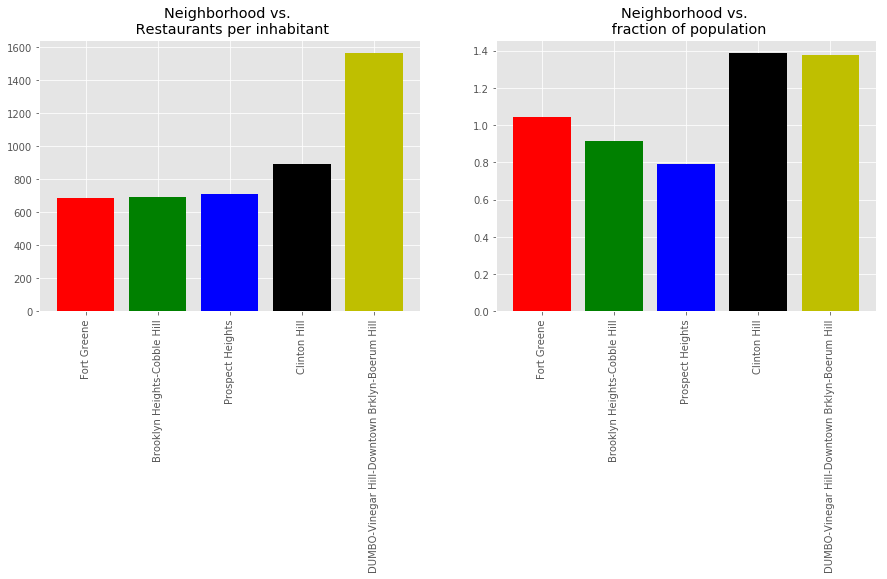

In [80]:
df_bar1=df_bar[df_bar['cluster']==0]
my_colors = 'rgbkymc'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(df_bar1['neigh_name'],df_bar1['res_per_ab'],color=my_colors,alpha=1)
axs[0].set_title('Neighborhood vs. \n Restaurants per inhabitant')
axs[1].bar(df_bar1['neigh_name'],df_bar1['frac_pop'],color=my_colors,alpha=1)
axs[1].set_title('Neighborhood vs. \n fraction of population')

ite=[0,1]
for i in ite:
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)



plt.show()

According to this analysis ```DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill``` are places were the concentration of restaurants is lower if compared with respect to the other neighborhoods of the same cluster. However in this neighborhoods the fraction of population is higher. For this reason this is the neighborhood recommended for this cluster. Let us now study which kind of restaurants should be opened there.

In [81]:
df_rest1 = df_grup[df_grup['cluster']==0]
df_rest1.drop(['total','pop','res_per_ab','frac_pop','cluster'],axis=1,inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


At this point we sort the kind of restaurants according to their frequency of occurrence. This would give us a measure of the level of competition a new restaurant would have in the beginning.

In [82]:
def return_most_common_rest(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [83]:
num_top_venues = 20
indicators = ['st', 'nd', 'rd']

columns = ['neigh_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neigh_rest_sorted = pd.DataFrame(columns=columns)
neigh_rest_sorted['neigh_name'] = df_rest1['neigh_name']

for ind in np.arange(df_rest1.shape[0]):
    neigh_rest_sorted.iloc[ind, 1:] = return_most_common_rest(df_rest1.iloc[ind, :], num_top_venues)

neigh_rest_sorted[neigh_rest_sorted['neigh_name']=='DUMBO-Vinegar Hill-Downtown Brklyn-Boerum Hill'].T

,7
neigh_name,DUMBO-Vinegar Hill-Downtown Brklyn-Boerum Hill
1st Most Common Venue,Chinese
2nd Most Common Venue,Diner
3rd Most Common Venue,Sandwiches
4th Most Common Venue,African
5th Most Common Venue,Japanese
6th Most Common Venue,Sushi
7th Most Common Venue,Italian
8th Most Common Venue,Indian
9th Most Common Venue,Mexican


Given these data we can deduce the following recomandation on the kind of restaurnats that should be open in ```DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill```. From the data available, we can only deduce which are the kind of restaurants where the level of competitions is higher. For instance a Chinese restaurant would have an higher level of competition with respect to a Mexican, Greek or a French restaurant in the beginning. For this reason, we do not recommend to open restaurant whose category lies in the top of this chart.

##### Cluster 1: medium commerical, medium residential

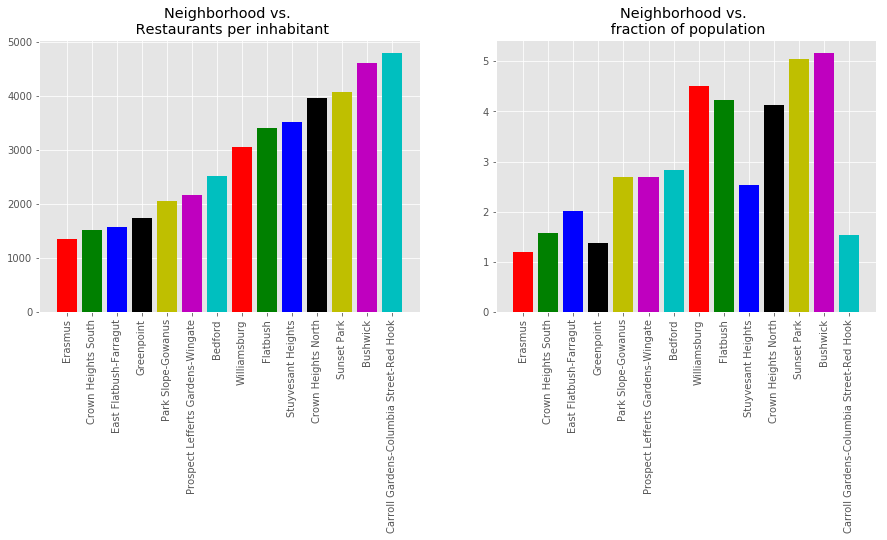

In [84]:
df_bar2=df_bar[df_bar['cluster']==1]
my_colors = 'rgbkymc'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(df_bar2['neigh_name'],df_bar2['res_per_ab'],color=my_colors,alpha=1)
axs[0].set_title('Neighborhood vs. \n Restaurants per inhabitant')
axs[1].bar(df_bar2['neigh_name'],df_bar2['frac_pop'],color=my_colors,alpha=1)
axs[1].set_title('Neighborhood vs. \n fraction of population')

ite=[0,1]
for i in ite:
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)



plt.show()

There are two neighborhoods having the right features to be recommended: ```Bushwick``` and ```Sunset Park```. Both have higher fraction of population and a low restaurant density.

In [85]:
df_rest2 = df_grup[df_grup['cluster']==1]
df_rest2.drop(['total','pop','res_per_ab','frac_pop','cluster'],axis=1,inplace=True)

/home/jupyterlab/conda/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [86]:
num_top_venues = 20
indicators = ['st', 'nd', 'rd']

columns = ['neigh_name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))


neigh_rest_sorted = pd.DataFrame(columns=columns)
neigh_rest_sorted['neigh_name'] = df_rest2['neigh_name']

for ind in np.arange(df_rest2.shape[0]):
    neigh_rest_sorted.iloc[ind, 1:] = return_most_common_rest(df_rest2.iloc[ind, :], num_top_venues)

neigh_rest_sorted[(neigh_rest_sorted['neigh_name']=='Bushwick') | (neigh_rest_sorted['neigh_name']=='Sunset Park')].T

,29,33
neigh_name,Sunset Park,Bushwick
1st Most Common Venue,Chinese,Chinese
2nd Most Common Venue,Mexican,Spanish
3rd Most Common Venue,Latin American,Pizza
4th Most Common Venue,Spanish,Mexican
5th Most Common Venue,Caribbean,Latin American
6th Most Common Venue,Sandwiches,Asian
7th Most Common Venue,Asian,Caribbean
8th Most Common Venue,American,Deli / Bodega
9th Most Common Venue,Cantonese,Kebab


Again the top part of this list conatin the kind of restaurants that will have the higher level of competition and for this reason it is recommended to avoid to open this kind of restaurants.

##### Cluster 2: low commericial, high residential

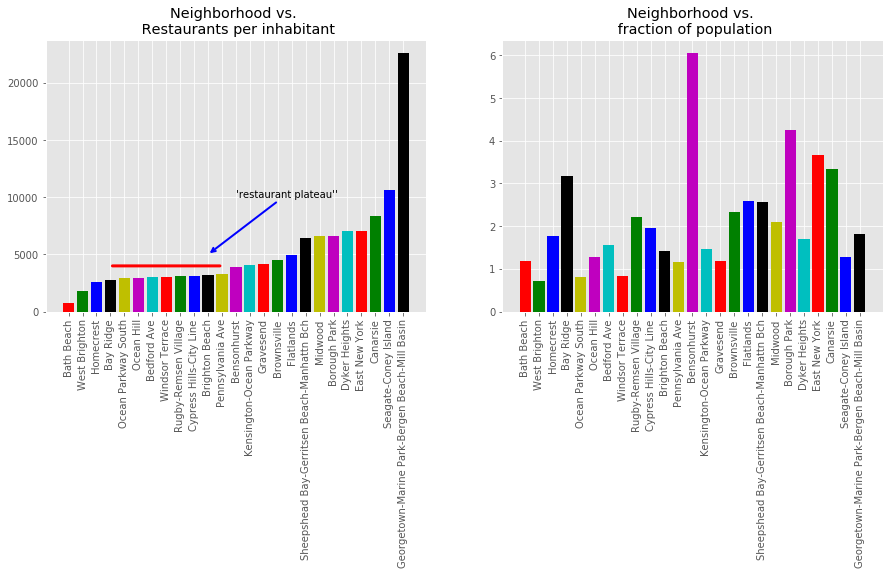

In [62]:
df_bar3=df_bar[df_bar['cluster']==2]
my_colors = 'rgbkymc'

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].bar(df_bar3['neigh_name'],df_bar3['res_per_ab'],color=my_colors,alpha=1)
axs[0].set_title('Neighborhood vs. \n Restaurants per inhabitant')
axs[0].annotate("\'restaurant plateau\''", xy=(10, 5000), xytext=(12, 10000),
                arrowprops=dict(arrowstyle="->",connectionstyle='arc3', color='blue', lw=2) )
axs[0].annotate("", xy=(3, 4000), xytext=(11, 4000),
                arrowprops=dict(arrowstyle="-",connectionstyle='arc3', color='red', lw=3) )
axs[1].bar(df_bar3['neigh_name'],df_bar3['frac_pop'],color=my_colors,alpha=1)
axs[1].set_title('Neighborhood vs. \n fraction of population')

ite=[0,1]
for i in ite:
    for tick in axs[i].get_xticklabels():
        tick.set_rotation(90)

plt.show()

This cluster should be the one associated to residential areas. Hence in this case we expect low density concentration on average. In particular we have the following average value of the res_per_ab parameter:

In [91]:
print('cluster 0: ',df_bar1['res_per_ab'].mean())
print('cluster 1: ',df_bar2['res_per_ab'].mean())
print('cluster 2: ',df_bar3['res_per_ab'].mean())

cluster 0:  909.7599999999999
cluster 1:  2885.2571428571428
cluster 2:  5178.04


This is in agreement with the fact that we consider cluster 2 as residential. For this reason, the ```res_per_ab``` as parameter is not as good as before. Probably the best neighborhoods are the one belonging to the 'restaurant plateau' indicated by the arrow in the first graph. This because a too low restaurant density (i.e. too high res_per_ab parameter) may indicate a very high residential area (so a very low visibility of the restaurant which is not good for a new restaurant). Among the neighborhoods belonging to the plateau, the ones having an high fraction of population should be better (like ```Bay Ridge```). However, no specific recommendation can be done on this area on the base of the data at disposal.

To conclude let us draw the recommended neighborhoods on the Brooklyn map. 

In [64]:
best_neigh=['DUMBO-Vinegar Hill-Downtown Brklyn-Boerum Hill','Bushwick','Sunset Park']

for lat, lng, name, re in zip(df_ny2['lat'], df_ny2['lon'], df_ny2['neigh_name'],df_grup['res_per_ab']):
    if name in best_neigh:
        label = fo.Popup(name+', There is a restaurant every '+str(re)+' inhabitants.', parse_html=True)
        fo.CircleMarker(
            [lat, lng],
            radius=10,
            popup=label,
            color='red',
            fill=True,
            fill_color='magenta',
            fill_opacity=0.8,
            parse_html=False).add_to(map_bro)  
    
map_bro

Let us now find which are the restaurant categories having the higest compotition. Hence we recoment to open a restaurant of a category different from the one we will find. This because the follwing category of restaurants are present but nor to much and so the competition is lower. The fact that these categories of restaurant are already present, suggest that the restaurant category is alreday 'accepted' by the population. 

### Conclusion.

We found where a restaurant can be open in Brooklyn and also detremined which are the category of restaurants having the lower level of competiotion in that area. However this analysis can be imporeved in the following point:

1. _Better geographic data_. We used Geopy to find the coodinated of the neighborhoods present in the NYcity database. However, we saw that sometimes Geopy does not distinguish two or more neighborhoods or even is unable to find them. The strategy used for this problem here is to aggregate neighborhoods having the same coordinates. This increase the population in such neighborhoods affecting the final result. Thus better geographic data may give rise to more realistic recommendations.

2. _Add economic data_. Information on the average income for each neighborhoods would help in the classification of the neighborhoods and so to have a better recommendation system.

3. _Add restaurants rating data_.